# AI: Modeling Oceans and Climate Change 2022

An [IJCAI-ECAI 2022](https://ijcai-22.org/) Workshop [organized by Inria Chile Research Center](https://oceania.inria.cl/#aimocc-2022)

It is our distinct pleasure to invite you to the Workshop AI: Modeling Oceans and Climate Change (AIMOCC 2022) to be held in conjunction with the 31st International Joint Conference on Artificial Intelligence and the 25th European Conference on Artificial Intelligence (IJCAI-ECAI 2022) on July 23-29, 2022, in Messe Wien, Vienna, Austria.

The goal of this workshop is to bring together researchers that are interested and/or applying AI and ML techniques to problems related to marine biology, modeling, and climate change mitigation. We also expect to attract natural science researchers interested in learning about and applying modern AI and ML methods. Consequently, the workshop will be a first stone on building a multi-disciplinary community behind this research topic, with collaborating researchers that share problems, insights, code, data, benchmarks, training pipelines, etc. Together, we aim to ultimately address an urgent matter regarding the future of humankind, nature, and our planet.

This workshop has a related IJCAI-ECAI 2022 Challenge: [AI methods for determining ocean ecosystems from space: Combining genomic information, microscopic and satellite imagery.](https://oceania.inria.cl/#ai-ocean-challenge-2022)

## The goal of this notebook
- This short tutorial aims to show how to access to Plankton images datasets from [Ecotaxa](https://ecotaxa.obs-vlfr.fr/).

Credit: part of this information was provided by [Fabien Lombard](https://lov.imev-mer.fr/web/member/fabien-lombard/).

Ecotaxa (Picheral et al., 2017) contains over 188 million “objects”/images captured by different microscopes. Part of the dataset has been manually annotated. They also have an ML-based image classifier.

Ecotaxa data is available via an [API](https://ecotaxa.obs-vlfr.fr/api/docs) allowing to programatically query and download parts of the datasets that are both validated and under CC-BY license (which is the case for the Tara Ocean).

## This demo is based on [Jean-Olivier Irisson](https://www.obs-vlfr.fr/~irisson/)'s work. For detailed documentation, please to go to the original [repository](https://github.com/jiho/prepare_ecotaxa_datasets).

### In order to access EcoTaxa dataset using colab, it is necessary to install a few dependencies.

Installing dependencies:

In [ ]:
!pip install urllib3>=1.25.3
!pip install requests==2.23.0

In [ ]:
!pip install folium==0.2.1
!pip install datascience==0.10.6

Installing EcoTaxa API:

In [ ]:
pip install git+https://github.com/ecotaxa/ecotaxa_py_client.git

In [4]:
import os
import yaml

from tqdm import tqdm
import pandas as pd
import pyarrow as pa
from pyarrow import parquet as pq

import ecotaxa_py_client

from ecotaxa_py_client.api import authentification_api
from ecotaxa_py_client.model.login_req import LoginReq

from ecotaxa_py_client.api import objects_api

from ecotaxa_py_client.api import projects_api
from ecotaxa_py_client.model.project_filters import ProjectFilters

from ecotaxa_py_client.api import samples_api

from ecotaxa_py_client.api import taxonomy_tree_api
from ecotaxa_py_client.model.taxon_model import TaxonModel

import shutil
import urllib.request

from pyarrow.parquet import read_table

### Do not run the next cell code. 

- This is an EXAMPLE of the yaml file you have to create (in any text editor) in order to access to EcoTaxa. Do not forget save the text file in '.yaml' format before uploading it to your colab session.

- You must [register in EcoTaxa](https://ecotaxa.obs-vlfr.fr/register) to get a valid username and password.


In [ ]:
# DO NOT RUN THIS CELL

# EcoTaxa login info
ecotaxa_user : 'your_mail@mail.com'
ecotaxa_pass : 'your_password'

# Base directory to store the data (including the images)
base_dir : '/content/'

# Dataset name (usually based on the instrument)
# will be created as a sub directory of base_dir
dataset : 'Test'

# Numeric id of project to download
# you should have appropriate access rights to it:
# - either the project should be visible to all
# - or you should be explicitly registered to it, as viewer at least
proj_id : 185

grouping:
  # Path or URL of a taxonomic grouping file
  # should have level0, level1, level2, etc. columns
  # level0 is current EcoTaxa classif and level1, etc. are increasingly coarse regrouping
  url : 'https://docs.google.com/spreadsheets/d/1_w3HAC1ofSDc6ipyMUAhlHv6J7OuCgNlZbnmro4Cw6A/edit#gid=1129062147'
  # Grouping level to use (level1 or level2 or...)
  level : 'level1'

# Split into train, val, test split
split_props:
  val : 0.15
  test : 0.15
# NB: train will be deduced from those

images:
  # Define if images are grayscale (or colour if False)
  grayscale : True
  # Number of pixels to crop at the bottom
  crop : 31
  # Whether to remove corners (remove all very dark parts)
  decorner: False
  # Thresholding parameters
  threshold: 4     # grey level (after inversion, in [0;255])
  dilate_erode: 0  # amount of pixels for dilation/erosion
  # Save only the thresholded particle;
  # otherwise saves the (possibly cropped) image
  save_particle: True
  # List of useless native features to remove
  useless_features : ['tag', 'x', 'y', 'bx', 'by', 'xstart', 'ystart']

# Uploading and reading the ***configuration.yaml*** file:

In [ ]:
# upload configuration.yaml file:
from google.colab import files
uploaded = files.upload()

In [5]:
# read configuration.yaml file:
with open(r'/content/Config.yaml') as config_file:
    cfg = yaml.safe_load(config_file)
print('### Download data for {}'.format(cfg['dataset']))

### Download data for Test


In [6]:
# prepare storage
data_dir = os.path.join(os.path.expanduser(cfg['base_dir']), cfg['dataset'])
os.makedirs(data_dir, exist_ok=True)

In [7]:
# authenticate in EcoTaxa
with ecotaxa_py_client.ApiClient() as client:
    api = authentification_api.AuthentificationApi(client)
    token = api.login(LoginReq(
      username='your_mail@mail.com',
      password='you_password'
    ))

In [8]:
config = ecotaxa_py_client.Configuration(
     access_token=token,discard_unknown_keys=True)

It is highly recommended to check out [this documentation](https://github.com/ecotaxa/ecotaxa_py_client/blob/main/docs/ObjectsApi.md#get_object_set) to access EcoTaxa porjects applying customized filters.

In [ ]:
# DO NOT RUN THIS CELL CODE.

# An example of several filters to access to projects that match with your interest.
# Options include to access images restincting by taxonomy or samples id, 
# geographical zones, ocean depth, dates, instrument used to collect iamges, and many more...

'''
    project_filters = ProjectFilters(
        taxo="12,7654,5409",
        taxochild="Y",
        statusfilter="NV",
        map_n="44.34",
        map_w="3.88",
        map_e="7.94",
        map_s="42.42",
        depthmin="10",
        depthmax="110",
        samples="10987,3456,987,38",
        instrum="uvp5",
        daytime="N,A",
        month="11,12",
        fromdate="2020-10-09",
        todate="2021-10-09",
        fromtime="1:17:00",
        totime="23:32:00",
        inverttime="0",
        validfromdate="2020-10-09 10:00:00",
        validtodate="2021-10-09 10:00:00",
        freenum="n01",
        freenumst="0",
        freenumend="999999",
        freetxt="p01",
        freetxtval="zooprocess",
        filt_annot="34,67,67",
        filt_last_annot="34,67",
    )
'''

In [9]:
# get validated objects and their metadata from project
with ecotaxa_py_client.ApiClient(config) as client:
    # list free fields for project
    projects_instance = projects_api.ProjectsApi(client)
    proj = projects_instance.project_query(cfg['proj_id'])
    obj_fields = ['fre.'+k for k in proj['obj_free_cols'].keys()]
    # TODO support several projects
    
    # get objects
    objects_instance = objects_api.ObjectsApi(client)
    # only validated
    filters = ProjectFilters(statusfilter="V")
    # get taxonomic name and image file name and all free fields
    fields = 'txo.id,txo.display_name,img.file_name,obj.latitude,obj.longitude,'+\
      ','.join(obj_fields)
    # TODO also gather who sorted to be able to write the list of authors
    
    # fetch one object to get the total number of objects to fetch
    objs = objects_instance.get_object_set(
        cfg['proj_id'], 
        filters,
        fields=fields, 
        window_start=0, 
        window_size=1)

    # fetch per sample
    samples_instance = samples_api.SamplesApi(client)
    samples = samples_instance.samples_search(
      project_ids=str(cfg['proj_id']),
      id_pattern="%"
    )
    
    # prepare storage
    objs_dfs = []

    with tqdm(total=objs['total_ids']) as pbar:
        for sam in samples:
            # update filters to add sampleid
            filters.samples = str(sam['sampleid'])
            
            # fetch a batch of objects
            objs = objects_instance.get_object_set(cfg['proj_id'], filters,
              fields=fields)
            n_fetched_objs = len(objs.details)
            
            # format retrieved data as a DataFrame
            objs_df = pd.DataFrame(objs['details'], columns=fields.split(','))
            # add object id as an identifier
            objs_df['objid'] = objs['object_ids']
            
            # store with the previous batches
            objs_dfs.append(objs_df)
            # and update progress bar
            ok = pbar.update(n_fetched_objs)

100%|██████████| 412/412 [00:05<00:00, 76.86it/s] 


In [10]:
# combine all batches in a single DataFrame
df = pd.concat(objs_dfs, ignore_index=True)
# fix id column types
df['txo.id'] = df['txo.id'].astype('int32')
df['objid'] = df['objid'].astype('int32')

df.head(5)

,txo.id,txo.display_name,img.file_name,obj.latitude,obj.longitude,fre.lat_end,fre.lon_end,fre.area,fre.mean,fre.stddev,...,fre.centroids,fre.cv,fre.sr,fre.perimareaexc,fre.feretareaexc,fre.perimferet,fre.perimmajor,fre.circex,fre.cdexc,objid
0,84963,detritus,26332/9830.jpg,24.858455,123.839817,0.0,0.0,702.0,135.696581,71.379642,...,0.000000,52.322615,36.410256,4.378138,1.396475,3.135135,3.314286,0.655588,0.000000,236050513
1,84963,detritus,26332/9765.jpg,24.858455,123.839817,0.0,0.0,3114.0,216.850353,25.803230,...,0.000000,11.989835,18.055556,7.315838,1.959278,3.733945,4.573034,0.234791,0.000000,236050448
2,84963,detritus,26332/9828.jpg,24.858455,123.839817,0.0,0.0,1530.0,201.959477,37.594472,...,2.236068,18.815656,25.850340,9.027572,2.097056,4.304878,5.883333,0.154194,0.057185,236050511
3,84963,detritus,26332/9839.jpg,24.858455,123.839817,0.0,0.0,1401.0,178.619557,53.665992,...,1.000000,30.231852,32.335329,6.251681,1.923594,3.250000,3.656250,0.321526,0.026717,236050522
4,84963,detritus,26332/9846.jpg,24.858455,123.839817,0.0,0.0,848.0,136.845519,76.017698,...,1.000000,55.537076,38.190955,4.569934,1.408777,3.243902,3.500000,0.601714,0.034360,236050529


In [11]:
# get all unique taxa ids
taxo_ids = list(set(df['txo.id']))
# get lineage for each
with ecotaxa_py_client.ApiClient(config) as client:
    taxo_instance = taxonomy_tree_api.TaxonomyTreeApi(client)
    taxa = [taxo_instance.query_taxa(t) for t in taxo_ids]

lineages = ['/' + '/'.join(t['lineage'][::-1]) for t in taxa]
lineages

['/not-living/detritus',
 '/not-living/artefact/badfocus',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Arthropoda/Crustacea/Maxillopoda/Copepoda/Calanoida/Acartiidae',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Cnidaria/Hydrozoa/Hydroidolina/Siphonophorae/Calycophorae/Diphyidae',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Cnidaria/Hydrozoa/Hydroidolina/Siphonophorae/Calycophorae/Abylidae',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Cnidaria/Hydrozoa/Hydroidolina/Siphonophorae/Calycophorae/Abylidae/Abylopsis/Abylopsis tetragona/eudoxie',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Arthropoda/Crustacea/Maxillopoda/Copepoda/Calanoida',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Mollusca/Gastropoda/Caenogastropoda/Hypsogastropoda/Etrema',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Arthropoda/Crustacea/Maxillopoda/Copepoda/Cyclopoida/Oithonidae',
 '/living/Eukaryota/Opisthokonta/Holozoa/Metazoa/Chordata/Tunicata/Thaliacea/Salpida',
 '/living/Eukaryota

In [12]:
# add lineages to the DataFrame
taxo = pd.DataFrame({'lineage': lineages}, index=taxo_ids)
df = df.join(taxo, on='txo.id')

In [13]:
df

,txo.id,txo.display_name,img.file_name,obj.latitude,obj.longitude,fre.lat_end,fre.lon_end,fre.area,fre.mean,fre.stddev,...,fre.cv,fre.sr,fre.perimareaexc,fre.feretareaexc,fre.perimferet,fre.perimmajor,fre.circex,fre.cdexc,objid,lineage
0,84963,detritus,26332/9830.jpg,24.858455,123.839817,0.0,0.0,702.0,135.696581,71.379642,...,52.322615,36.410256,4.378138,1.396475,3.135135,3.314286,0.655588,0.000000,236050513,/not-living/detritus
1,84963,detritus,26332/9765.jpg,24.858455,123.839817,0.0,0.0,3114.0,216.850353,25.803230,...,11.989835,18.055556,7.315838,1.959278,3.733945,4.573034,0.234791,0.000000,236050448,/not-living/detritus
2,84963,detritus,26332/9828.jpg,24.858455,123.839817,0.0,0.0,1530.0,201.959477,37.594472,...,18.815656,25.850340,9.027572,2.097056,4.304878,5.883333,0.154194,0.057185,236050511,/not-living/detritus
3,84963,detritus,26332/9839.jpg,24.858455,123.839817,0.0,0.0,1401.0,178.619557,53.665992,...,30.231852,32.335329,6.251681,1.923594,3.250000,3.656250,0.321526,0.026717,236050522,/not-living/detritus
4,84963,detritus,26332/9846.jpg,24.858455,123.839817,0.0,0.0,848.0,136.845519,76.017698,...,55.537076,38.190955,4.569934,1.408777,3.243902,3.500000,0.601714,0.034360,236050529,/not-living/detritus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,61996,Acartiidae,2447/4127.jpg,43.685000,7.315667,None,None,2632.0,184.480000,40.915000,...,22.282609,29.078014,0.177752,0.049312,3.604651,5.670732,70.393202,-0.000382,24479673,/living/Eukaryota/Opisthokonta/Holozoa/Metazoa...
408,84963,detritus,2447/4665.jpg,43.685000,7.315667,None,None,703.0,224.660000,14.147000,...,6.222222,22.580645,0.255014,0.074499,3.423077,4.045455,49.837083,0.005731,24480211,/not-living/detritus
409,61996,Acartiidae,2447/5100.jpg,43.685000,7.315667,None,None,3113.0,181.560000,41.574000,...,23.076923,31.578947,0.150804,0.034727,4.342593,5.329545,82.975398,0.001286,24480646,/living/Eukaryota/Opisthokonta/Holozoa/Metazoa...
410,84963,detritus,2447/4698.jpg,43.685000,7.315667,None,None,1072.0,163.600000,52.769000,...,32.317073,27.894737,0.145658,0.044818,3.250000,3.250000,85.180905,0.003735,24480244,/not-living/detritus


In [14]:
# compute number of examples per class
inventory = df.groupby(['lineage', 'txo.id', 'txo.display_name']).size().reset_index(name='n0')
inventory = inventory.rename(columns={'txo.id':'id', 'txo.display_name':'level0'})

print('  downloaded {} objects. Saving them'.format(df.shape[0]))

  downloaded 412 objects. Saving them


In [15]:
# write to disk
pq.write_table(
  pa.Table.from_pandas(df),
  where=os.path.join(data_dir, 'orig_extraction.parquet'),
  compression='NONE' # for compatibility with R
)

inventory.to_csv(os.path.join(data_dir, 'orig_inventory.tsv'), sep='\t', index=False)

### Download images to your local session:

In [16]:
# prepare storage
data_dir = os.path.join(os.path.expanduser(cfg['base_dir']), cfg['dataset'])
img_dir = os.path.join(data_dir, 'orig_imgs')
os.makedirs(img_dir, exist_ok=True)

In [17]:
# read data from EcoTaxa
df = read_table(os.path.join(data_dir, 'orig_extraction.parquet')).to_pandas()
df.shape

(412, 76)

In [18]:
# detect image extension
file,ext = os.path.splitext(df['img.file_name'][0])
# TODO extract file extension for each file, like in step 4.
# name image according to internal object_id to ensure uniqueness
df['dest_path'] = [os.path.join(img_dir, str(this_id)+ext) for this_id in df['objid']]

In [19]:
# download images (with a nice progress bar)
vault_path = '/remote/ecotaxa/vault'
for i in tqdm(range(df.shape[0])):
  # if the file has not been copied already
  if not os.path.isfile(df['dest_path'][i]):
    # copy from vault
    if os.path.isdir(vault_path):
      res = shutil.copyfile(
        src=os.path.join(vault_path, df['img.file_name'][i]),
        dst=df['dest_path'][i]
      )
    # or copy through the internet
    else:
      res = urllib.request.urlretrieve(
        url='https://ecotaxa.obs-vlfr.fr/vault/'+df['img.file_name'][i],
        filename=df['dest_path'][i]
      )

n_imgs = len(os.listdir(img_dir))
print('  {} images in {}'.format(n_imgs, img_dir))

100%|██████████| 412/412 [00:49<00:00,  8.38it/s]

  412 images in /content/Test/orig_imgs


### Plotting examples:

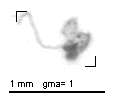

-1

In [37]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

img = cv2.imread(img_dir+"/236050511.jpg")
cv2_imshow(img)
cv2.waitKey()

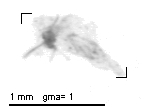

-1

In [38]:
img = cv2.imread(img_dir+"/236050448.jpg")
cv2_imshow(img)
cv2.waitKey()